In [4]:
###
#1. define data analysis and workflow
###

#imporing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss

In [5]:
#Load the raw data
try:
    df = pd.read_csv('../data/raw/BrentOilPrices.csv', parse_dates=['Date'], index_col='Date')
    print("File loaded successfully.") 
    print(df.count)
except FileNotFoundError:
    print("File not found. Please check the file path.")
df.head()

C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_6888\831695080.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../data/raw/BrentOilPrices.csv', parse_dates=['Date'], index_col='Date')


File loaded successfully.
<bound method DataFrame.count of             Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63
...           ...
2022-11-08  96.85
2022-11-09  93.05
2022-11-10  94.25
2022-11-11  96.37
2022-11-14  93.59

[9011 rows x 1 columns]>


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [6]:
#sort the dataframe by date
df = df.sort_index()
df = df.asfreq('D')
df["Price"] = df["Price"].interpolate()
df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 12963 entries, 1987-05-20 to 2022-11-14
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   12963 non-null  float64
dtypes: float64(1)
memory usage: 202.5 KB


In [7]:
#handling missing values
df = df.dropna()
print(f"Missing values after handling: {df.isnull().sum().sum()}")
print(df.describe())

Missing values after handling: 0
              Price
count  12963.000000
mean      48.523273
std       32.976876
min        9.100000
25%       19.050000
50%       38.753333
75%       70.353333
max      143.950000


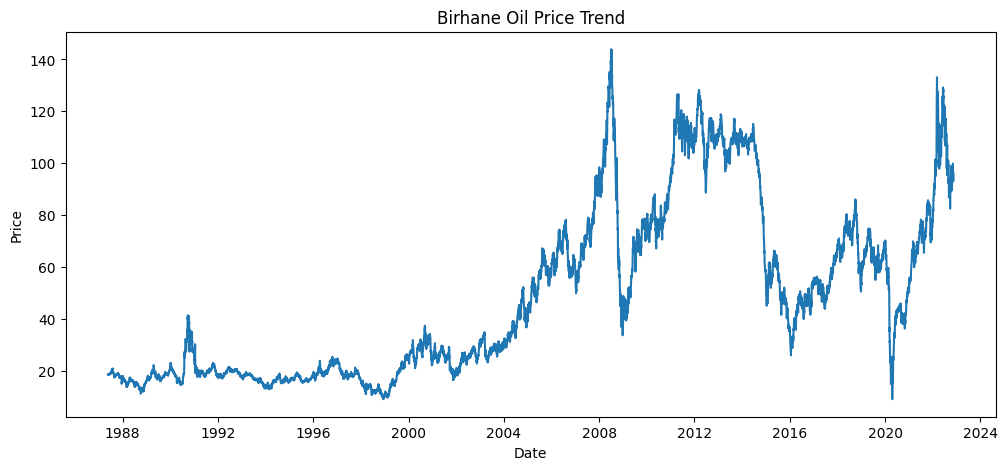

In [8]:
#price Trend
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Price"])
plt.title("Birhane Oil Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [9]:
import pandas as pd
import os

# Create event table (improved)
events_data = {
    "Date": [
        "1990-08-02", 
        "1997-07-02",  
        "2001-09-11", 
        "2003-03-20",  
        "2008-09-15",  
        "2011-02-15", 
        "2014-11-27",
        "2016-01-16",
        "2016-11-30",
        "2018-05-08",
        "2019-09-14",
        "2020-03-11",
        "2020-04-12",
        "2021-11-26",
        "2022-02-24",
        "2022-03-08",
        "2022-10-05",
        "2023-04-02",
        "2023-10-07",
        "2024-06-02"
    ],
    "Event": [
        "Iraq invades Kuwait (Gulf War begins)",
        "Asian Financial Crisis begins",
        "9/11 attacks in the US",
        "Iraq War begins",
        "Lehman collapse (Global Financial Crisis shock)",
        "Arab Spring / Libya supply disruption",
        "OPEC keeps production high",
        "Iran sanctions lifted",
        "OPEC production cut agreement",
        "US exits Iran nuclear deal",
        "Saudi Aramco attacked",
        "COVID-19 declared pandemic",
        "OPEC+ historic cut",
        "Omicron variant shock",
        "Russia invades Ukraine",
        "US bans Russian oil",
        "OPEC+ output cuts",
        "Surprise OPEC+ cut",
        "Middle East conflict",
        "OPEC+ extends cuts"
    ],
    "Category": [
        "War", "Economic Crisis", "Geopolitical", "War", "Economic Crisis",
        "Geopolitical", "OPEC Decision", "Sanctions", "OPEC Decision",
        "Sanctions", "Geopolitical", "Pandemic", "OPEC Decision",
        "Pandemic", "War", "Sanctions", "OPEC Decision", "OPEC Decision",
        "Geopolitical", "OPEC Decision"
    ],
    "Region": [
        "Middle East", "Asia", "US", "Middle East", "Global",
        "Middle East", "Global", "Middle East", "Global",
        "Middle East", "Middle East", "Global", "Global",
        "Global", "Europe", "Global", "Global", "Global",
        "Middle East", "Global"
    ],
    "Expected_Impact": [
        "Supply shock", "Demand shock", "Risk premium", "Supply shock",
        "Demand shock", "Supply shock", "Supply increase",
        "Supply increase", "Supply cut", "Supply risk",
        "Supply disruption", "Demand collapse", "Supply cut",
        "Demand fear", "Supply risk", "Supply reduction",
        "Supply cut", "Supply cut", "Risk premium",
        "Supply cut"
    ],
    "Confidence": [
        "High", "Medium", "Medium", "High", "High",
        "Medium", "High", "High", "High",
        "High", "High", "High", "High",
        "Medium", "High", "High", "High", "High",
        "Medium", "High"
    ]
}

events = pd.DataFrame(events_data)

# Convert Date column
events["Date"] = pd.to_datetime(events["Date"])

# Sort by Date
events = events.sort_values("Date").reset_index(drop=True)

# Ensure directory exists
output_path = "../data/events"
os.makedirs(output_path, exist_ok=True)

# Save to CSV
events.to_csv(f"{output_path}/events.csv", index=False)

print(events)

         Date                                            Event  \
0  1990-08-02            Iraq invades Kuwait (Gulf War begins)   
1  1997-07-02                    Asian Financial Crisis begins   
2  2001-09-11                           9/11 attacks in the US   
3  2003-03-20                                  Iraq War begins   
4  2008-09-15  Lehman collapse (Global Financial Crisis shock)   
5  2011-02-15            Arab Spring / Libya supply disruption   
6  2014-11-27                       OPEC keeps production high   
7  2016-01-16                            Iran sanctions lifted   
8  2016-11-30                    OPEC production cut agreement   
9  2018-05-08                       US exits Iran nuclear deal   
10 2019-09-14                            Saudi Aramco attacked   
11 2020-03-11                       COVID-19 declared pandemic   
12 2020-04-12                               OPEC+ historic cut   
13 2021-11-26                            Omicron variant shock   
14 2022-02

📌 Event Table Structure

The event dataset captures major global shocks that potentially impact oil markets. Each row represents a historical event with the following fields:

Date – The calendar date of the event.

Event – A short description of what occurred.

Category – Type of shock (War, Sanctions, OPEC Decision, Pandemic, Economic Crisis).

Region – Geographical area mainly affected.

Expected_Impact – Economic intuition behind the shock (supply cut, demand collapse, risk premium, etc.).

Confidence – Subjective confidence level about the event’s relevance to oil prices.

Events are merged with the price series using a ±5 day window to capture delayed or anticipatory market reactions. Days inside this window are labeled as Event = 1, and others as Event = 0.

This structure allows systematic comparison between event-driven and normal market behavior.

In [10]:
#attach data to the event 
df["Event"] = 0

for d in events["Date"]:
    if d in df.index:
        df.loc[d, "Event"] = 1

In [11]:
# create event window
window = 5

for d in events["Date"]:
    df.loc[d - pd.Timedelta(days=window): d + pd.Timedelta(days=window), "Event"] = 1

#comparing event with normal data
event_days = df[df["Event"] == 1]["Price"]
normal_days = df[df["Event"] == 0]["Price"]

print("Event Mean Price:", event_days.mean())
print("Normal Mean Price:", normal_days.mean())


Event Mean Price: 60.731417112299475
Normal Mean Price: 48.34458476831559


In [12]:
stat, p, _, _ = kpss(df["Price"], regression='c')
print("KPSS Statistic:", stat)
print("KPSS p-value:", p)

for d in events["Date"]:
    start = d - pd.Timedelta(days=window)
    end = d + pd.Timedelta(days=window)
    df.loc[start:end, "Event"] = 1

KPSS Statistic: 11.177756700403952
KPSS p-value: 0.01


C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_6888\1176085188.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, _, _ = kpss(df["Price"], regression='c')


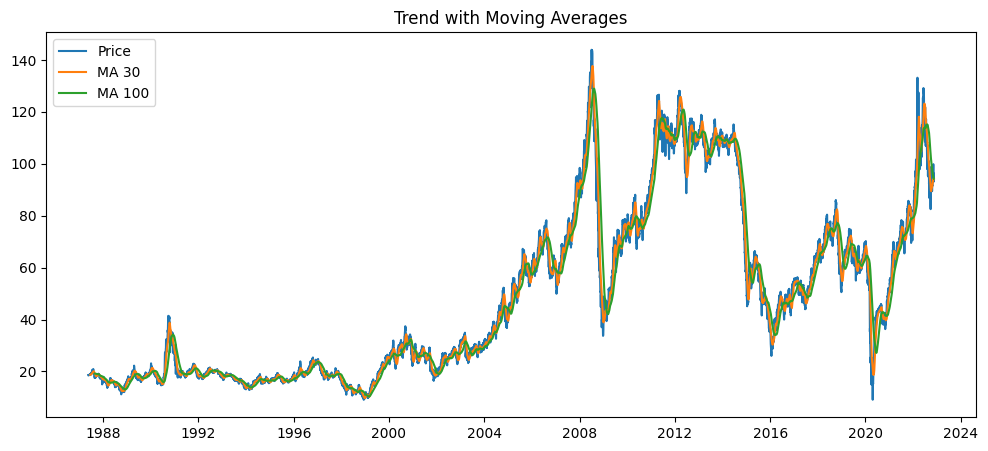

In [13]:
###
#2. Understanding the Model and Data:
###

# trend analysis
df["MA_30"] = df["Price"].rolling(30).mean()
df["MA_100"] = df["Price"].rolling(100).mean()

plt.figure(figsize=(12,5))
plt.plot(df["Price"], label="Price")
plt.plot(df["MA_30"], label="MA 30")
plt.plot(df["MA_100"], label="MA 100")
plt.legend()
plt.title("Trend with Moving Averages")
plt.show()


In [14]:
#create return
df["Return"] = df["Price"].pct_change()
df = df.dropna()

In [15]:
#ADF test in price
adf_price = adfuller(df["Price"])
print("ADF Test on Price")
print("ADF Price Statistic:", adf_price[0])
print("ADF Price p-value:", adf_price[1])

print()
#ADF test on Return
adf_return = adfuller(df["Return"])
print("ADF Test on Return")
print("ADF Return Statistic:", adf_return[0])
print("ADF Return p-value:", adf_return[1])


ADF Test on Price
ADF Price Statistic: -1.9571743202426526
ADF Price p-value: 0.30566039263583134

ADF Test on Return
ADF Return Statistic: -19.594962313846267
ADF Return p-value: 0.0


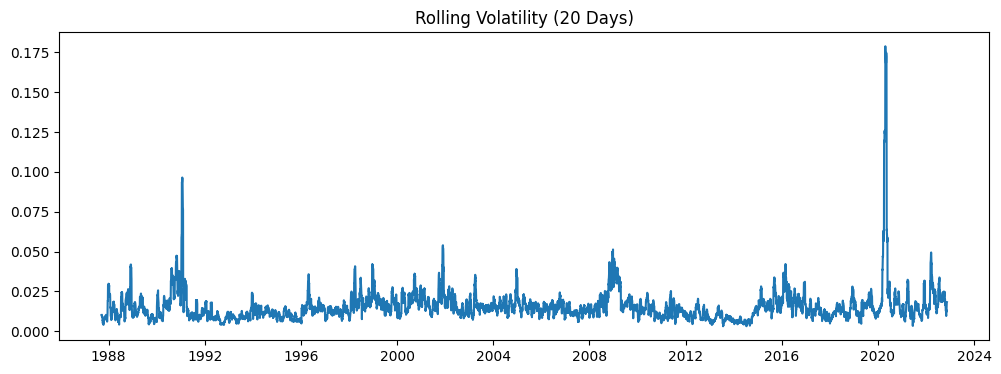

In [16]:
# volatility pattern
df["Volatility"] = df["Return"].rolling(20).std()

plt.figure(figsize=(12,4))
plt.plot(df["Volatility"])
plt.title("Rolling Volatility (20 Days)")
plt.show()

In [17]:
#prepare for change point model
series = df["Price"].values

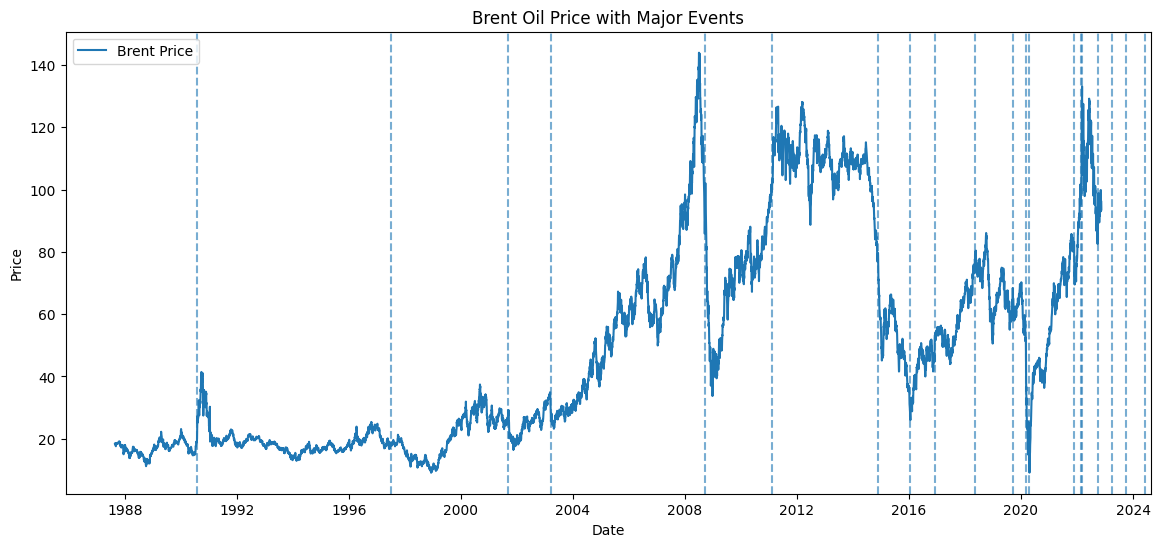

In [18]:
#price chart with event lines
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Price"], label="Brent Price")

for d in events["Date"]:
    plt.axvline(d, linestyle="--", alpha=0.6)

plt.title("Brent Oil Price with Major Events")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [19]:
df["Return"] = df["Price"].pct_change()
df["Volatility"] = df["Return"].rolling(20).std()
df["MA_30"] = df["Price"].rolling(30).mean()
df["MA_100"] = df["Price"].rolling(100).mean()

df = df.dropna()
print(df.columns)

Index(['Price', 'Event', 'MA_30', 'MA_100', 'Return', 'Volatility'], dtype='str')


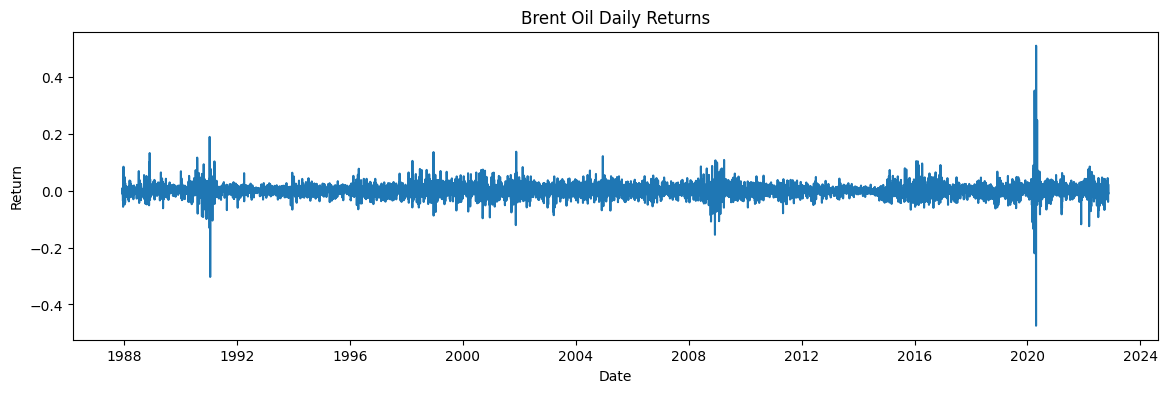

In [20]:
#return time series plot
plt.figure(figsize=(14,4))
plt.plot(df.index, df["Return"])
plt.title("Brent Oil Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()


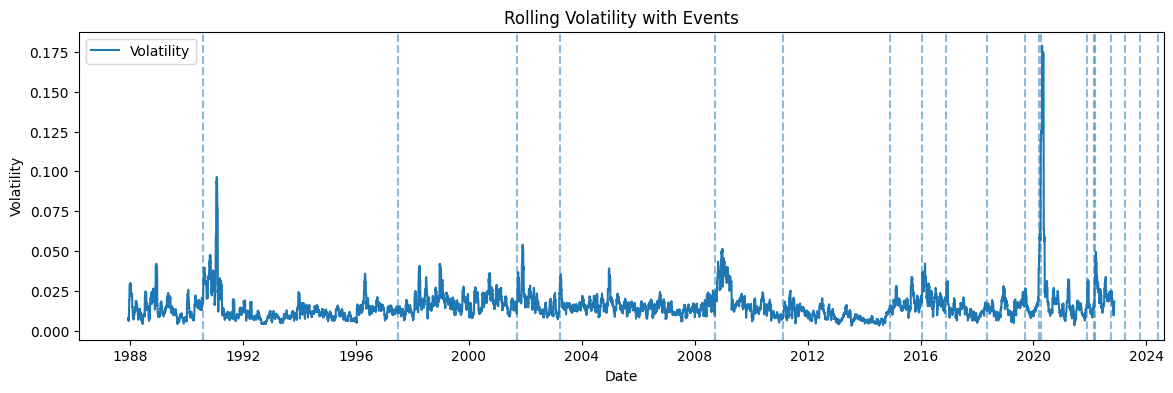

In [21]:
#volatile with event
plt.figure(figsize=(14,4))
plt.plot(df.index, df["Volatility"], label="Volatility")

for d in events["Date"]:
    plt.axvline(d, linestyle="--", alpha=0.5)

plt.title("Rolling Volatility with Events")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()


C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_6888\2703857157.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([event_returns, normal_returns], labels=["Event Days", "Normal Days"])


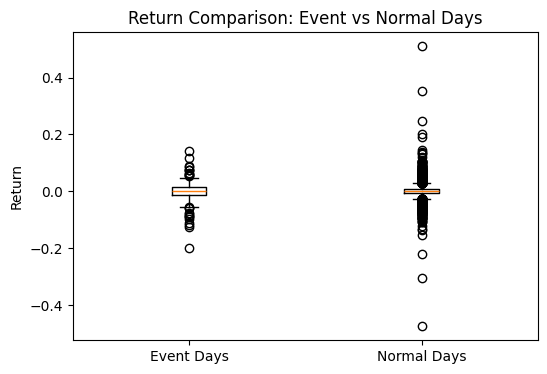

In [22]:
#event with normal
event_returns = df[df["Event"] == 1]["Return"]
normal_returns = df[df["Event"] == 0]["Return"]

plt.figure(figsize=(6,4))
plt.boxplot([event_returns, normal_returns], labels=["Event Days", "Normal Days"])
plt.title("Return Comparison: Event vs Normal Days")
plt.ylabel("Return")
plt.show()


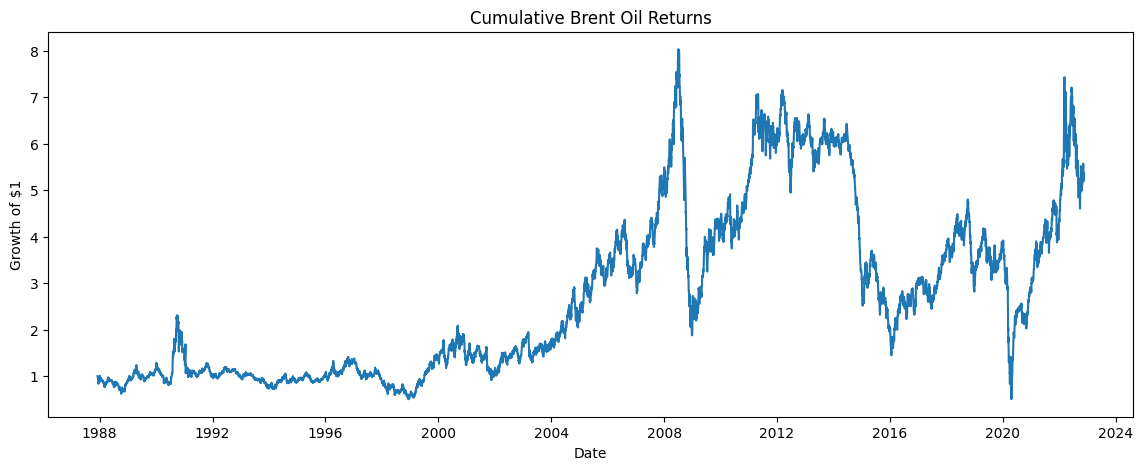

In [23]:
#commulative return plot
df["Cumulative_Return"] = (1 + df["Return"]).cumprod()

plt.figure(figsize=(14,5))
plt.plot(df.index, df["Cumulative_Return"])
plt.title("Cumulative Brent Oil Returns")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.show()


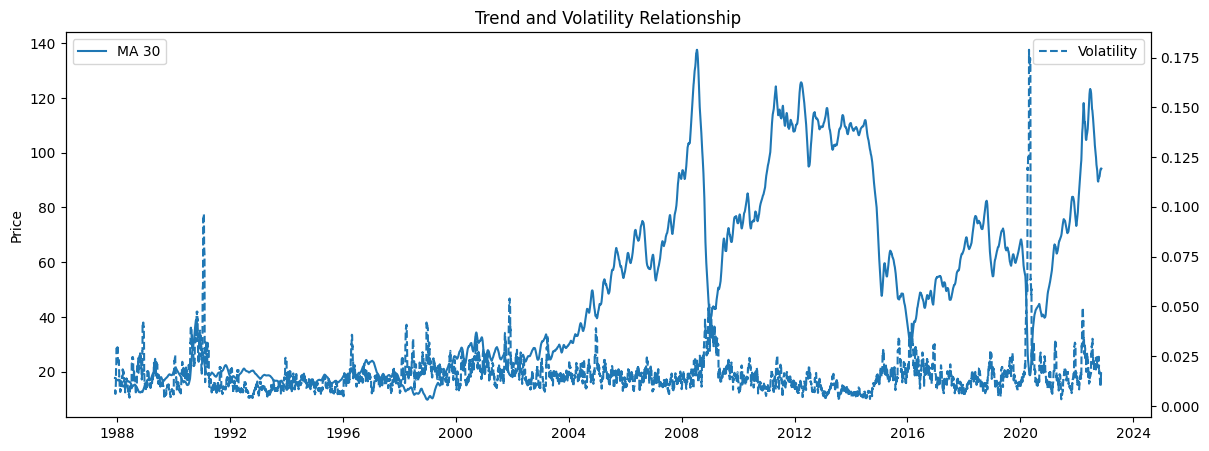

In [24]:
#rolling mean with volatile
fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(df.index, df["MA_30"], label="MA 30")
ax1.set_ylabel("Price")

ax2 = ax1.twinx()
ax2.plot(df.index, df["Volatility"], linestyle="--", label="Volatility")

ax1.set_title("Trend and Volatility Relationship")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


📌 Analysis Workflow

This project analyzes how major geopolitical, economic, and policy events affect Brent oil prices. The workflow follows these steps:

Data Loading & Cleaning
The raw Brent oil price data is loaded, sorted by date, converted to daily frequency, and missing values are interpolated.

Exploratory Data Analysis (EDA)
Price trends, moving averages, returns, volatility, and cumulative returns are visualized to understand long-term behavior and short-term fluctuations.

Event Engineering
A structured table of major historical events is created. Each event is mapped to the price series with a ±5-day event window.

Statistical Testing
Stationarity is tested using ADF and KPSS on prices and returns.

Event vs Normal Comparison
Returns and prices during event windows are compared against normal periods using summary statistics and boxplots.

Volatility Analysis
Rolling volatility is computed and visualized alongside events to detect instability during shocks.

Preparation for Change-Point Modeling
The cleaned price series is prepared for structural break detection.

This workflow ensures the analysis moves from raw data to interpretable insights in a structured and reproducible way.

📌 Assumptions and Limitations

This analysis is based on several assumptions:

Markets react within a short window (±5 days) around major events.

Events listed are representative of major oil price drivers.

Daily prices adequately capture market reactions.

⚠️ Limitations

Correlation vs Causation:
The analysis identifies statistical relationships, not direct causality. A price move near an event does not prove the event caused it.

Overlapping Events:
Some events occur close together, making individual impacts difficult to isolate.

Omitted Variables:
Macroeconomic indicators, currency effects, inventory levels, and speculation are not explicitly modeled.

Window Choice Sensitivity:
Results depend on the chosen ±5-day event window.

Therefore, findings should be interpreted as associations, not guaranteed causal effects.

📌 Change-Point Modeling Approach

To detect structural breaks in Brent oil prices, the project prepares the series for a change-point model. The objective is to identify dates where the statistical behavior of prices shifts significantly.

🎯 Model Idea

The model assumes that:

Price behavior can be divided into regimes.

Each regime has its own mean and volatility.

A latent change point (τ) separates regimes.

A Bayesian change-point framework estimates:

τ (tau) – the most probable break date.

μ₁, μ₂ – average price/return before and after the break.

σ₁, σ₂ – volatility before and after the break.

📊 Expected Outputs

The model produces:

Posterior distribution of the change point date.

Regime-specific means and volatility.

Business interpretation such as:
“After the detected break, average returns increased while volatility shifted, indicating a new market regime.”